# Learning to Play the Zoning Game: Supervised

Let's actually do some machine learning. Here, we will train a neural network to mimic a greedy policy and a greedy value function by supervised learning. We will play a bunch of random games and take the output of some greedy policy (either `polich_indiv_greedy` or `policy_total_greedy`), alongside the "current grid score," as training data for a neural network with a policy head and a value head.

In [45]:
import logging
from multiprocessing import Pool

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

from nsai_experiments.zoning_game.zg_gym import ZoningGameEnv, flatten_zg_obs, Tile
from nsai_experiments.zoning_game.zg_policy import create_policy_random, create_policy_indiv_greedy

from nsai_experiments.zoning_game.notebook_utils import create_dataset_1_one_game

In [2]:
DEVICE = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

## Part 1: no streaming, random policy, only train value
Here, we focus on a single-headed value network and we use a pre-determined policy to generate a bunch of data ahead of time.

In [43]:
shuffle_before_split = True
valid_frac = 0.15
test_frac = 0.15

def generate_zg_data(policy_creator, n_games = 10_000):
    states = []
    values = []
    moves = []
    with Pool() as pool:
        # Due to a limitation in `multiprocessing` we had to define `create_dataset_1_one_game` in a separate file
        # (see https://stackoverflow.com/questions/41385708/)
        results = pool.starmap(create_dataset_1_one_game,
                               [(policy_creator, game_i+n_games, game_i) for game_i in range(n_games)])
    for my_states, my_values, my_moves in results:
        states.extend(my_states)
        values.extend(my_values)
        moves.extend(my_moves)
    return np.array(states), np.array(values), np.array(moves)

# Not using moves data yet
states, values, _ = generate_zg_data(create_policy_random)

print(states.shape)
print(values.shape)

states_tensor = torch.tensor(states, dtype=torch.long)
values_tensor = torch.tensor(values, dtype=torch.float32)

(216143, 72)
(216143,)


In [4]:
torch.manual_seed(47)
full_dataset = TensorDataset(states_tensor, values_tensor)
if shuffle_before_split:
    indices = torch.randperm(len(full_dataset))
    full_dataset = TensorDataset(states_tensor[indices], values_tensor[indices])

valid_size = int(valid_frac * len(full_dataset))
test_size = int(test_frac * len(full_dataset))
train_size = len(full_dataset) - valid_size - test_size

# Perform the split
train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [train_size, valid_size, test_size])

print(f"Train size: {len(train_dataset)}, validation size: {len(valid_dataset)}, test size: {len(test_dataset)}")

Train size: 151301, validation size: 32421, test size: 32421


In [5]:
class StepOneValueNetwork(nn.Module):
    def __init__(self, grid_size = 6):
        super().__init__()

        input_length = grid_size*grid_size*2
        one_hot_length = input_length * len(Tile)  # 432

        # n_hidden_1 = one_hot_length*2
        # n_hidden_2 = one_hot_length
        # n_hidden_3 = input_length
        # self.linear_relu_stack = nn.Sequential(
        #     nn.Linear(one_hot_length, n_hidden_1),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden_1, n_hidden_2),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden_2, n_hidden_3),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden_3, 1)
        # )

        # Best val loss: 2.4 after 50 epochs
        # n_hidden = 2592
        # self.linear_relu_stack = nn.Sequential(
        #     nn.Linear(one_hot_length, n_hidden),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden, n_hidden),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden, 1)
        # )

        # n_hidden = 2592
        # self.linear_relu_stack = nn.Sequential(
        #     nn.Linear(one_hot_length, n_hidden),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden, 1)
        # )

        # n_hidden = 432
        # self.linear_relu_stack = nn.Sequential(
        #     nn.Linear(one_hot_length, n_hidden),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden, n_hidden),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden, 1)
        # )

        # Best val loss 32: 2.7 after 50 epochs
        # Best val loss 54: 2.1 after 50 epochs
        # out_channels = 32
        # self.conv1 = nn.Conv2d(len(Tile), out_channels, kernel_size=3, stride=1, padding=1)
        # n_hidden = 432
        # self.linear_relu_stack = nn.Sequential(
        #     nn.ReLU(),
        #     nn.Linear(input_length*out_channels//2, n_hidden),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden, n_hidden),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden, 1)
        # )
        # x = x[:, :36]
        # x = x.reshape(-1, 6, 6)
        # x = F.one_hot(x, num_classes=len(Tile)).to(torch.float32)
        # x = self.conv1(x)
        # x = torch.flatten(x, start_dim=1)
        # x = self.linear_relu_stack(x)
        # return x

        out_channels = 54
        self.conv1 = nn.Conv2d(len(Tile), out_channels, kernel_size=3, stride=1, padding=1)
        n_hidden = 432
        self.linear_relu_stack = nn.Sequential(
            nn.ReLU(),
            nn.Linear(input_length*out_channels//2, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1)
        )


    def forward(self, x):
        x = x[:, :36]
        x = x.reshape(-1, 6, 6)
        x = F.one_hot(x, num_classes=len(Tile)).to(torch.float32)
        x = self.conv1(x)
        x = torch.flatten(x, start_dim=1)
        x = self.linear_relu_stack(x)
        return x

In [6]:
def train_step_one_value_network(model, train_dataset, valid_dataset, epochs=10, batch_size=1024, learning_rate=0.002, l1_lambda = 1e-4, weight_decay = 5e-2, device = DEVICE):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    torch.manual_seed(47)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

    train_mini_losses = []
    train_losses = []
    valid_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)

            # Add L1 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss += l1_lambda * l1_norm

            loss.backward()
            optimizer.step()
            loss = loss.item()
            train_mini_losses.append(loss)
            train_loss += loss

        # Validation phase
        model.eval()
        valid_loss = 0.0
        abs_differences = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                valid_loss += loss.item()
                abs_differences.extend(torch.abs(outputs.squeeze() - targets).cpu().numpy())

        # Record losses
        train_losses.append(train_loss / len(train_loader))
        valid_losses.append(valid_loss / len(val_loader))

        # Calculate max, min, and mean absolute differences
        max_abs_diff = np.max(abs_differences)
        min_abs_diff = np.min(abs_differences)
        mean_abs_diff = np.mean(abs_differences)

        # Print epoch summary
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {valid_losses[-1]:.4f}, "
              f"Max Abs Diff: {max_abs_diff:.4f}, Min Abs Diff: {min_abs_diff:.4f}, Mean Abs Diff: {mean_abs_diff:.4f}")

    return model, train_mini_losses, train_losses, valid_losses

def plot_learning_curve(train_mini_losses, train_losses, valid_losses, log_scale = False):
    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.scatter(np.linspace(0, len(train_losses)-1, len(train_mini_losses)), train_mini_losses, label='Train Mini Loss', s=5, color='gray')
    plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
    plt.plot(range(len(valid_losses)), valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curve')
    if log_scale: plt.yscale('log')
    plt.xlim([0, len(train_losses)-1])
    plt.legend()
    plt.grid(True)
    plt.show()

100%|██████████| 148/148 [00:02<00:00, 50.35it/s]


Epoch 1/5, Train Loss: 125.6233, Val Loss: 48.1666, Max Abs Diff: 33.2419, Min Abs Diff: 0.0007, Mean Abs Diff: 5.4307


100%|██████████| 148/148 [00:02<00:00, 60.09it/s]


Epoch 2/5, Train Loss: 29.5920, Val Loss: 17.3668, Max Abs Diff: 21.1708, Min Abs Diff: 0.0003, Mean Abs Diff: 3.2550


100%|██████████| 148/148 [00:02<00:00, 58.56it/s]


Epoch 3/5, Train Loss: 15.3729, Val Loss: 11.1009, Max Abs Diff: 16.0458, Min Abs Diff: 0.0000, Mean Abs Diff: 2.6152


100%|██████████| 148/148 [00:02<00:00, 61.71it/s]


Epoch 4/5, Train Loss: 11.8737, Val Loss: 8.8296, Max Abs Diff: 15.7772, Min Abs Diff: 0.0000, Mean Abs Diff: 2.3309


100%|██████████| 148/148 [00:02<00:00, 64.06it/s]


Epoch 5/5, Train Loss: 9.7566, Val Loss: 8.6315, Max Abs Diff: 15.9126, Min Abs Diff: 0.0000, Mean Abs Diff: 2.3062


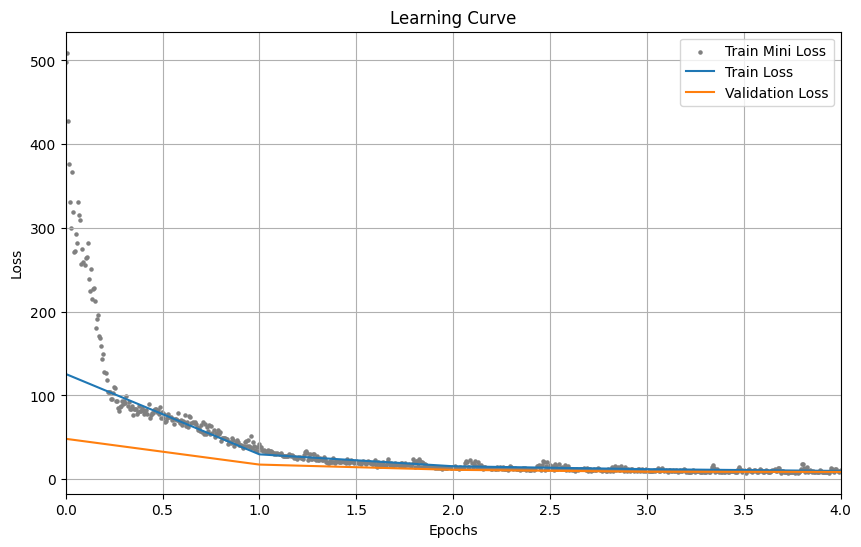

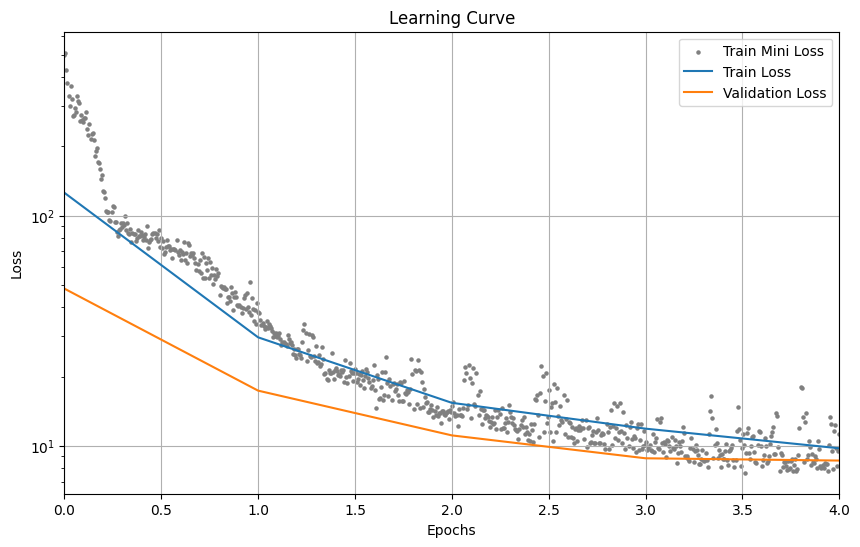

In [7]:
model = StepOneValueNetwork()
model, train_mini_losses, train_losses, valid_losses = train_step_one_value_network(model, train_dataset, valid_dataset, epochs = 5)

plot_learning_curve(train_mini_losses, train_losses, valid_losses)
plot_learning_curve(train_mini_losses, train_losses, valid_losses, log_scale = True)

## Part 2: No streaming, individual greedy policy, only train policy 

Success. Now, same thing but we want to learn the policy, not the value. We'll try to learn the `indiv_greedy` policy.

In [ ]:
states, _, moves = generate_zg_data(create_policy_indiv_greedy, n_games = 20_000)

print(states.shape)
print(moves.shape)

states_tensor = torch.tensor(states, dtype=torch.long)
moves_tensor = torch.tensor(moves, dtype=torch.float32)

(432252, 72)
(432252,)


In [71]:
torch.manual_seed(47)
full_dataset_2 = TensorDataset(states_tensor, moves_tensor)
if shuffle_before_split:
    indices = torch.randperm(len(full_dataset_2))
    full_dataset_2 = TensorDataset(states_tensor[indices], moves_tensor[indices])

valid_size_2 = int(valid_frac * len(full_dataset_2))
test_size_2 = int(test_frac * len(full_dataset_2))
train_size_2 = len(full_dataset_2) - valid_size_2 - test_size_2

# Perform the split
train_dataset_2, valid_dataset_2, test_dataset_2 = random_split(full_dataset_2, [train_size_2, valid_size_2, test_size_2])

print(f"Train size: {len(train_dataset_2)}, validation size: {len(valid_dataset_2)}, test size: {len(test_dataset_2)}")

Train size: 302578, validation size: 64837, test size: 64837


In [72]:
class StepTwoPolicyNetwork(nn.Module):
    def __init__(self, grid_size = 6):
        super().__init__()
        self.grid_size = grid_size
        self.grid_length = grid_size*grid_size
        self.input_length = self.grid_length*2
        self.num_classes = len(Tile)

        kernel_size = 3
        out_channels = self.num_classes*kernel_size*kernel_size
        n_into_linear = self.grid_length*out_channels + self.grid_length*self.num_classes
        n_hidden = self.input_length*self.num_classes
        
        self.conv1 = nn.Conv2d(self.num_classes, out_channels, kernel_size=kernel_size, stride=1, padding=1)
        self.linear_relu_stack = nn.Sequential(
            nn.ReLU(),
            nn.Linear(n_into_linear, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU()
        )
        self.policy_head = nn.Linear(n_hidden, self.grid_length)
        self.value_head = nn.Linear(n_hidden, 1)


    def forward(self, x):
        assert x.shape[1] == self.input_length
        x = F.one_hot(x, num_classes=self.num_classes).to(torch.float32)

        x_grid = x[:, :self.grid_length, :].reshape(-1, self.grid_size, self.grid_size, self.num_classes)
        x_grid = self.conv1(x_grid)
        x_grid = torch.flatten(x_grid, start_dim=1)

        x_queue = x[:, self.grid_length:]
        x_queue = torch.flatten(x_queue, start_dim=1)

        x = torch.cat((x_grid, x_queue), dim=1)
        x = self.linear_relu_stack(x)
        x = self.policy_head(x)
        return x

In [76]:
def train_step_two_policy_network(model, train_dataset, valid_dataset, epochs=10, batch_size=1024, learning_rate=0.001, l1_lambda = 0, weight_decay = 0, device = DEVICE):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

    train_mini_losses = []
    train_losses = []
    valid_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)

            # Add L1 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss += l1_lambda * l1_norm

            loss.backward()
            optimizer.step()
            loss = loss.item()
            train_mini_losses.append(loss)
            train_loss += loss

        # Validation phase
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                valid_loss += loss.item()

        # Record losses
        train_losses.append(train_loss / len(train_loader))
        valid_losses.append(valid_loss / len(val_loader))

        # Print epoch summary
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {valid_losses[-1]:.4f}, ")

    return model, train_mini_losses, train_losses, valid_losses

100%|██████████| 296/296 [00:05<00:00, 54.75it/s]


Epoch 1/10, Train Loss: 2.2669, Val Loss: 1.7739, 


100%|██████████| 296/296 [00:05<00:00, 56.99it/s]


Epoch 2/10, Train Loss: 1.7166, Val Loss: 1.6986, 


100%|██████████| 296/296 [00:05<00:00, 56.60it/s]


Epoch 3/10, Train Loss: 1.6543, Val Loss: 1.6922, 


100%|██████████| 296/296 [00:05<00:00, 57.16it/s]


Epoch 4/10, Train Loss: 1.6064, Val Loss: 1.6815, 


100%|██████████| 296/296 [00:05<00:00, 57.09it/s]


Epoch 5/10, Train Loss: 1.5641, Val Loss: 1.6469, 


100%|██████████| 296/296 [00:05<00:00, 56.80it/s]


Epoch 6/10, Train Loss: 1.5165, Val Loss: 1.6263, 


100%|██████████| 296/296 [00:05<00:00, 56.24it/s]


Epoch 7/10, Train Loss: 1.4723, Val Loss: 1.6067, 


100%|██████████| 296/296 [00:05<00:00, 57.32it/s]


Epoch 8/10, Train Loss: 1.4264, Val Loss: 1.5845, 


100%|██████████| 296/296 [00:05<00:00, 55.80it/s]


Epoch 9/10, Train Loss: 1.3713, Val Loss: 1.5714, 


100%|██████████| 296/296 [00:05<00:00, 56.51it/s]


Epoch 10/10, Train Loss: 1.3131, Val Loss: 1.5683, 


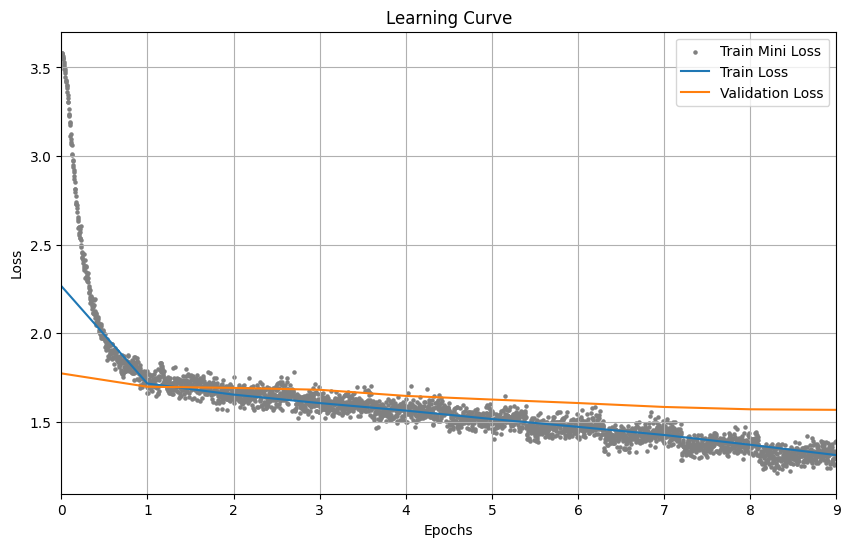

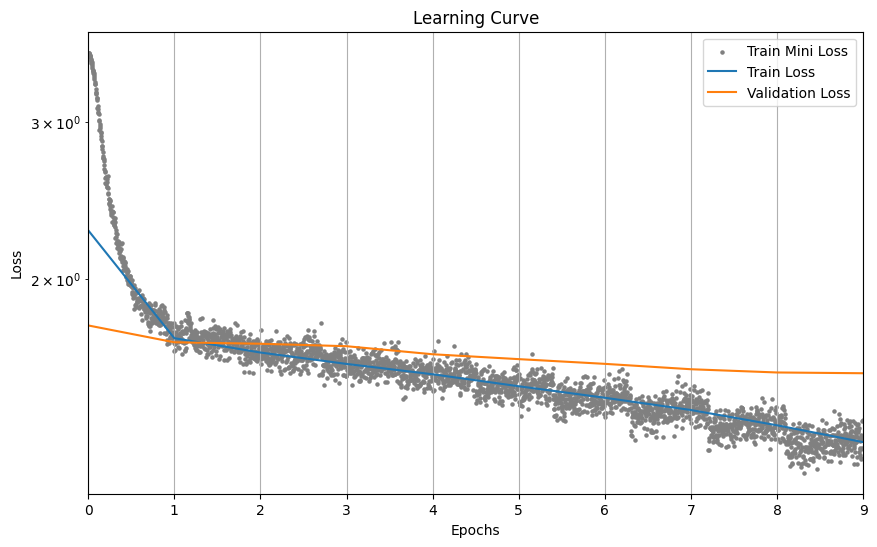

In [77]:
model = StepTwoPolicyNetwork()
model, train_mini_losses, train_losses, valid_losses = train_step_two_policy_network(model, train_dataset_2, valid_dataset_2, epochs = 10)

plot_learning_curve(train_mini_losses, train_losses, valid_losses)
plot_learning_curve(train_mini_losses, train_losses, valid_losses, log_scale = True)